In [2]:

# LSTM model dummy
# Dummy model to predict the climate time series data

# !nvidia-smi

import tensorflow as tf 
# !pip install tensorflow-gpu
print(tf.__version__)

print('1: ', tf.config.list_physical_devices('GPU'))
print('2: ', tf.test.is_built_with_cuda)
print('3: ', tf.test.gpu_device_name())
print('4: ', tf.config.get_visible_devices())

2.6.2
1:  []
2:  <function is_built_with_cuda at 0x7f5c3b3bab70>
3:  
4:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [3]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import pandas as pd
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, RepeatVector, TimeDistributed
import math
from sklearn.metrics import mean_squared_error , roc_curve, auc

## Data Processing

### Data Fetching and Cleaning

In [4]:


# create a dataset of 30 sequences from the provided Data
def creatDataset(x,y,time_step):
    Xs, Ys = [],[]
    for i in range(len(x)-time_step):
        v = x.iloc[i:i+time_step].values
        Xs.append(v)
        Ys.append(x.iloc[i+time_step])
    return np.array(Xs),np.array(Ys)
    

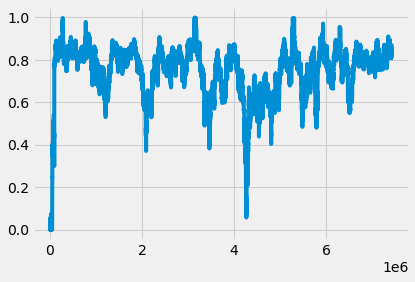

In [5]:
#getting data

scaler = MinMaxScaler()
df_normal = pd.read_csv('train_1.csv', delimiter=',')
df_normal_grp_ID1 = df_normal[df_normal['ID']=='id1'].dropna(axis=1, how='all')
df_normal_grp_ID1 = df_normal_grp_ID1.drop(df_normal_grp_ID1[['Label','ID']],axis =1)
# df_normal_grp_ID1 = df_normal_grp_ID1.iloc[0:(int(len(df_normal_grp_ID1)/5)),:]
# df_normal_grp_ID1 = df_normal_grp_ID1.iloc[200000:300000,:]
df_normal_grp_ID1[['Time']] = scaler.fit_transform(df_normal_grp_ID1[['Time']])
# df_normal_grp_ID1
plt.plot(df_normal_grp_ID1['Signal1'])

In [6]:
df_normal_grp_ID1['Signal1']

5          0.000000
12         0.000000
20         0.000000
27         0.000000
33         0.000000
             ...   
7417396    0.876350
7417403    0.876500
7417410    0.876641
7417417    0.876771
7417425    0.876901
Name: Signal1, Length: 1034952, dtype: float64

         Label      Time  Signal1_of_ID  Signal2_of_ID
1            0  0.000000       0.165060           0.25
7            0  0.000003       0.165400           0.50
16           0  0.000007       0.165821           0.75
22           0  0.000010       0.166301           1.00
29           0  0.000013       0.166662           0.00
...        ...       ...            ...            ...
2150020      0  0.999987       0.617179           0.75
2150028      0  0.999990       0.617330           1.00
2150035      0  0.999993       0.617460           0.00
2150043      0  0.999997       0.617570           0.25
2150048      0  1.000000       0.617650           0.50

[299997 rows x 4 columns]


Text(0.5, 1.0, 'Plateau Attack (180000-190000) values')

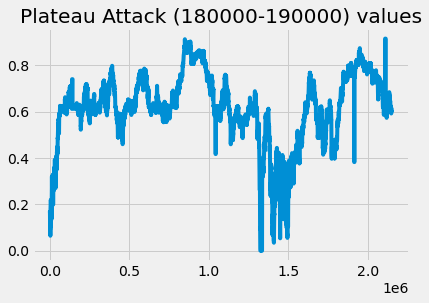

In [7]:
df_test_plat_ID1 = pd.read_csv('test_plateau.csv', delimiter=',')
df_test_plat_ID1 = df_test_plat_ID1[df_test_plat_ID1['ID']=='id1'].dropna(axis=1, how='all')
df_test_plat_ID1 = df_test_plat_ID1.drop(df_test_plat_ID1[['ID']],axis =1)
# df_test_plat_ID1 = df_test_plat_ID1.iloc[0:(int(len(df_test_plat_ID1)/5)),:]
# df_test_plat_ID1 = df_test_plat_ID1.iloc[180000:200000,:]
df_test_plat_ID1[['Time']] = scaler.fit_transform(df_test_plat_ID1[['Time']])

# df_test_plat_ID1.iloc[180000:250000,0:2]

# plt.plot(df_test_plat_ID1.iloc[180000:190000,1:2])
print(df_test_plat_ID1)
plt.plot(df_test_plat_ID1.iloc[:,2:3])
plt.title('Plateau Attack (180000-190000) values')

In [8]:
TIME_STEP = 30
X_train, Y_train = creatDataset(df_normal_grp_ID1[['Signal1']], df_normal_grp_ID1[['Signal1']], TIME_STEP)
X_test, Y_test = creatDataset(df_test_plat_ID1[['Signal1_of_ID']], df_test_plat_ID1[['Signal1_of_ID']], TIME_STEP)


In [9]:
Y_train.shape

# X_test.shape

(1034922, 1)

### LSTM AUTOENCODER
#### Model Desgin

In [16]:


# n_features = X_train.shape[2]
model= Sequential()
model.add(LSTM(128, activation = 'relu', 
input_shape =(X_train.shape[1],X_train.shape[2]), return_sequences = True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(RepeatVector(TIME_STEP))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 128)           66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 247,937
Trainable params: 247,937
Non-trainable params: 0
__________________________________________________

#### Model Fitting

In [19]:
# fit model
model.fit(X_train, Y_train, epochs=5, batch_size=30, validation_split=0.1, shuffle=False)
model.save("single_ID_LSTM_autoenc_old")

Epoch 1/5
31048/31048 [==============================] - 803s 26ms/step - loss: 0.0138 - val_loss: 0.0319
Epoch 2/5
31048/31048 [==============================] - 803s 26ms/step - loss: 0.0163 - val_loss: 0.0291
Epoch 3/5
31048/31048 [==============================] - 786s 25ms/step - loss: 0.0186 - val_loss: 0.0292
Epoch 4/5
31048/31048 [==============================] - 777s 25ms/step - loss: 0.0210 - val_loss: 0.0290
Epoch 5/5
31048/31048 [==============================] - 774s 25ms/step - loss: 0.0195 - val_loss: 0.0291
INFO:tensorflow:Assets written to: single_ID_LSTM_autoenc_old/assets


#### Training loss, finding Threshold

/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


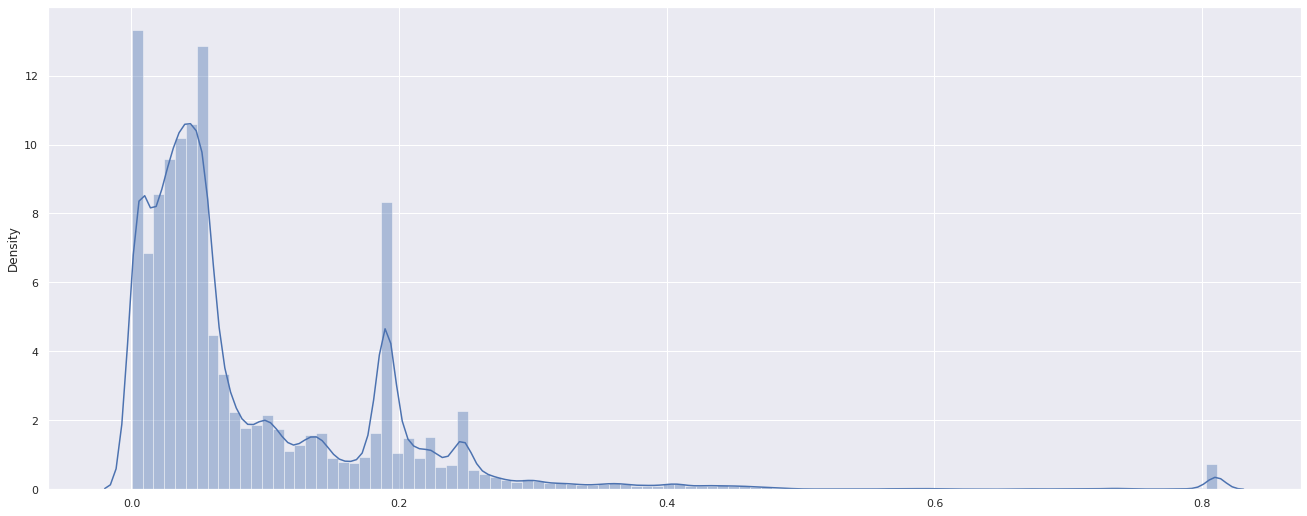

In [10]:
reconstructed_model = keras.models.load_model("single_ID_LSTM_autoenc_old")
x_train_predict = reconstructed_model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(x_train_predict - X_train), axis=1)
sns.set(rc={'figure.figsize':(20,8.27)})
sns.distplot(train_mae_loss,bins=100,kde=True)
plt.savefig('training_loss.png')


### Test Loss

In [123]:
THRESHOLD = 0.29

(299967, 1)


/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

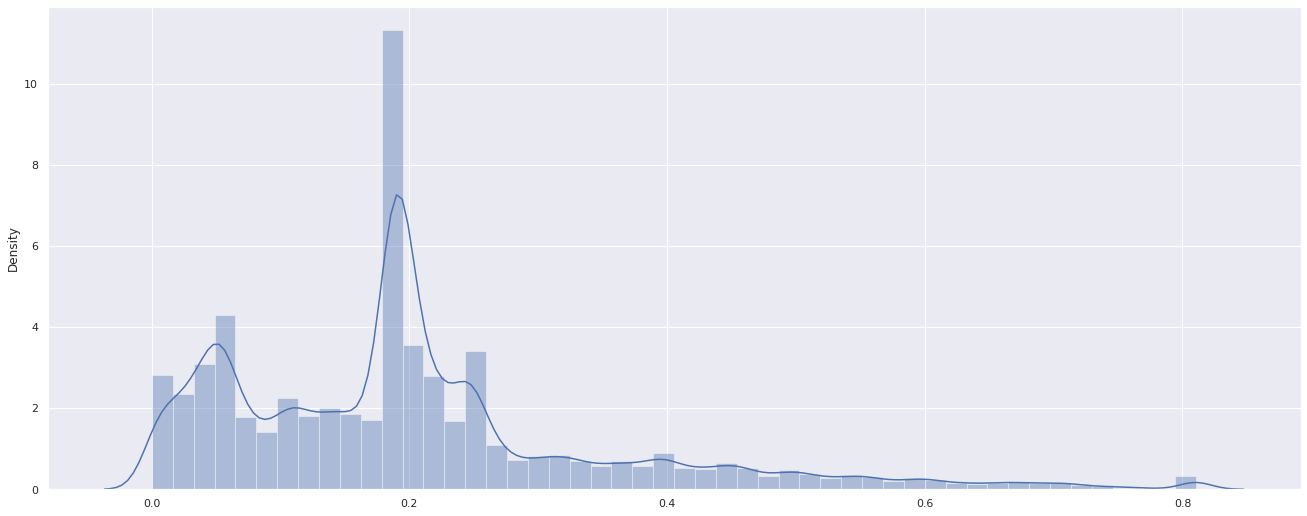

In [12]:

x_test_predict = reconstructed_model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(x_test_predict - X_test), axis=1)
print(test_mae_loss.shape)

sns.distplot(test_mae_loss,bins=50,kde=True )

### Test Score Dataframe Creation and plotting


In [13]:
print(df_test_plat_ID1[TIME_STEP:].index.shape)
print(test_mae_loss.shape)

(299967,)
(299967, 1)


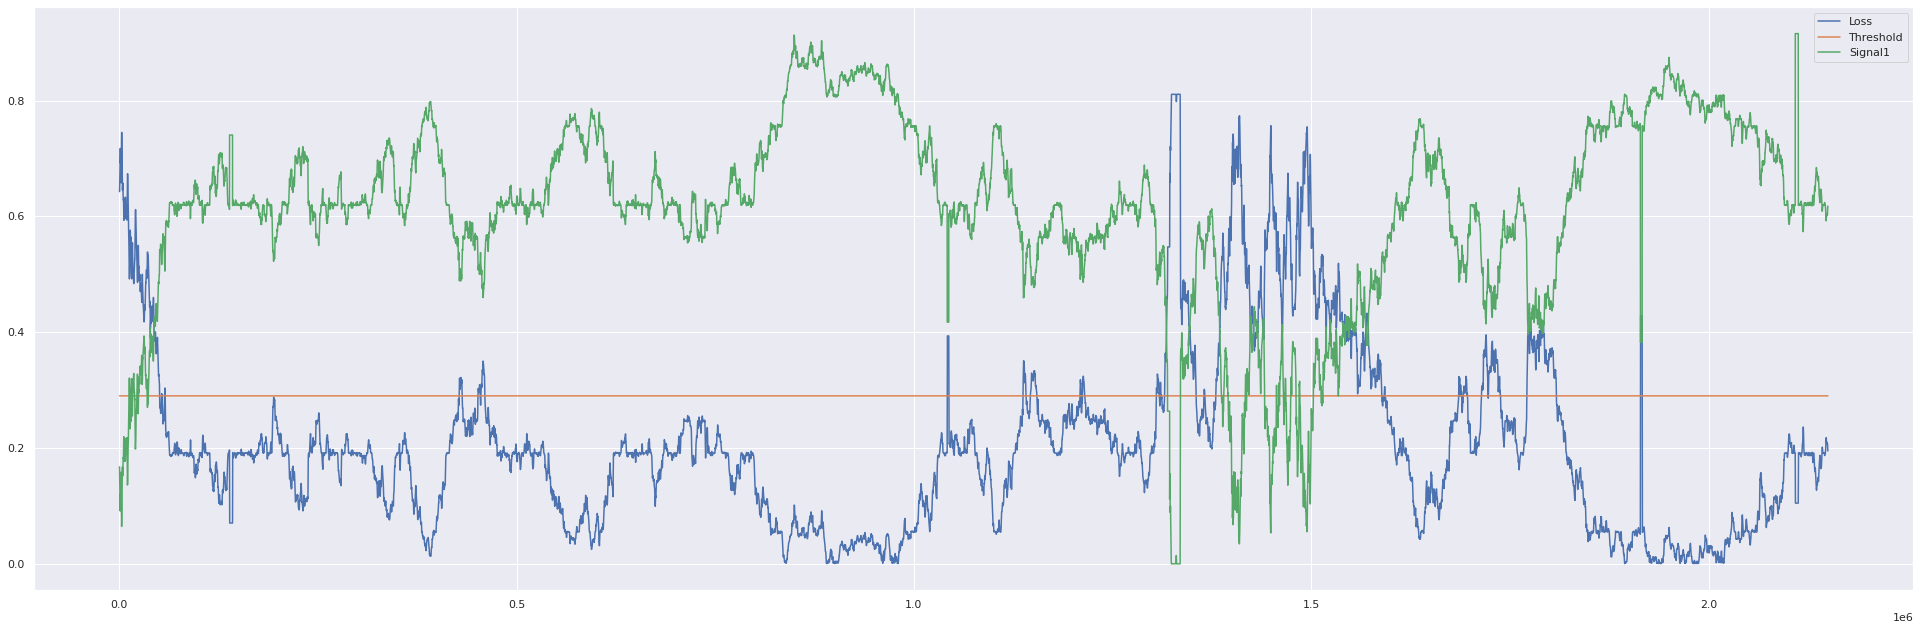

In [124]:
test_score_df = pd.DataFrame(index=df_test_plat_ID1[TIME_STEP:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['Signal1'] = df_test_plat_ID1[TIME_STEP:].Signal1_of_ID
test_score_df['Label'] = df_test_plat_ID1[TIME_STEP:].Label
#plot the threshoold vs the actual loss values
plt.figure(figsize=(30,10))
plt.plot(test_score_df.index, test_score_df.loss, label='Loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='Threshold')
plt.plot(test_score_df.index,test_score_df.Signal1, label='Signal1')
plt.legend()


#### Confusion Matrix Creation

In [125]:
anomalies = test_score_df[test_score_df.anomaly == True]
notAnomalies = test_score_df[test_score_df.anomaly == False]

stats = np.empty([1,4],dtype='int')

# For ID_1
TPs = anomalies[anomalies.Label == anomalies.anomaly]
stats[0][0] = TPs.iloc[:,0].shape[0]

FPs = anomalies[anomalies.Label != anomalies.anomaly]
stats[0][1] = FPs.iloc[:,0].shape[0]

FNs= notAnomalies[notAnomalies.Label != notAnomalies.anomaly]
stats[0][2] = FNs.iloc[:,0].shape[0]

TNs= notAnomalies[notAnomalies.Label == notAnomalies.anomaly]
stats[0][3] = TNs.iloc[:,0].shape[0]


print(anomalies.shape)
print(notAnomalies.head())
print(stats[0,0])
print(stats[0,1])
print(stats[0,2])
print(stats[0,3])

(57273, 5)
           loss  threshold  anomaly   Signal1  Label
50706  0.289446       0.29    False  0.534469      0
50712  0.288558       0.29    False  0.535270      0
50720  0.287675       0.29    False  0.536051      0
50726  0.286799       0.29    False  0.536842      0
50735  0.285928       0.29    False  0.537632      0
9659
47614
39302
203392


#### Total anomalies Plotted: Predicted VS Test 

/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


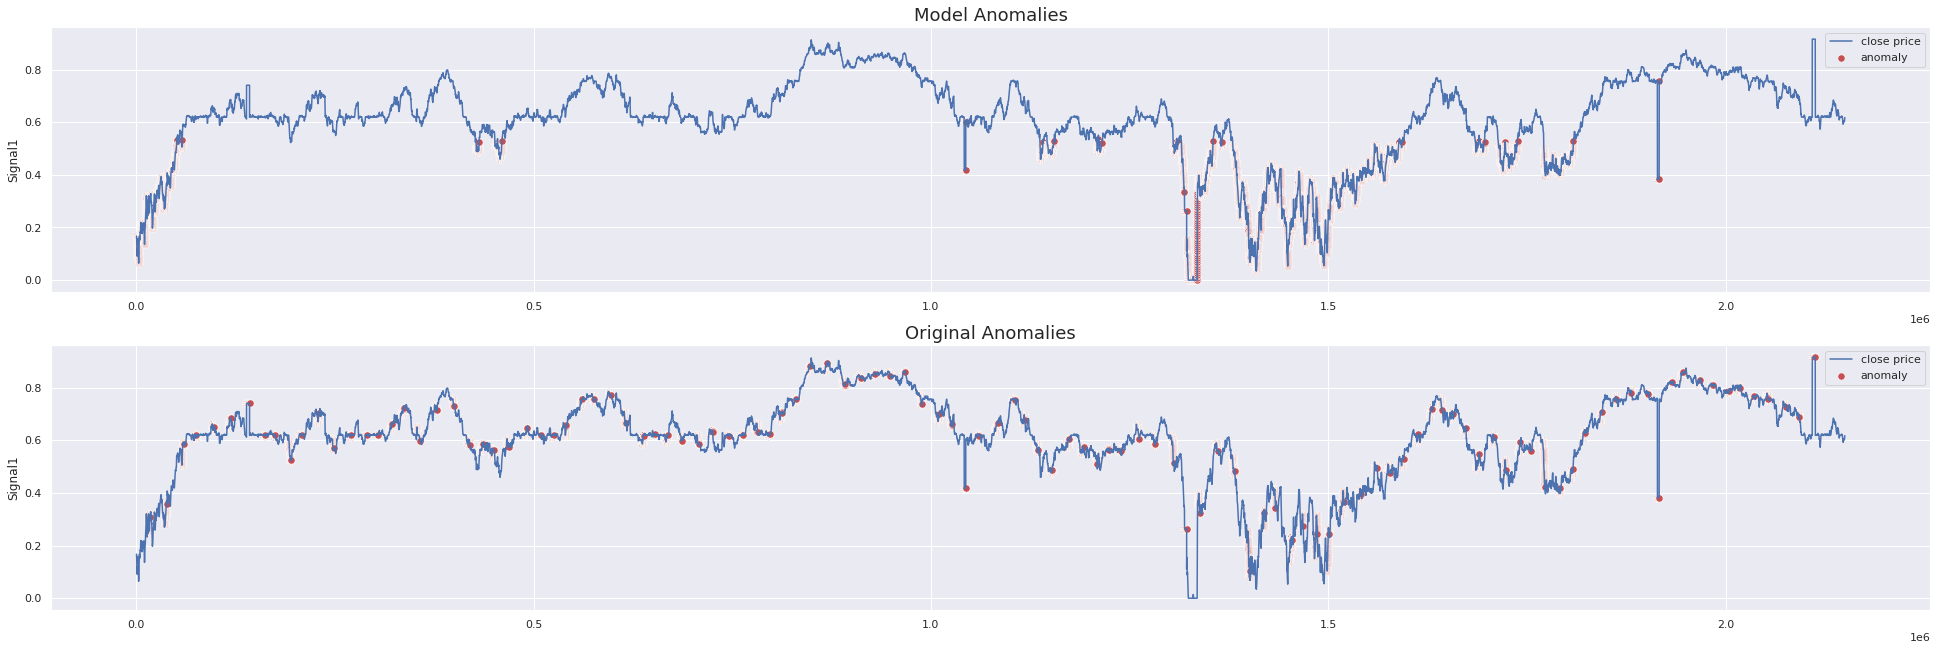

In [142]:
fig,axs = plt.subplots(2,1,squeeze=False, figsize=(30,10))
axs[0,0].set_title('Model Anomalies',fontsize=18)
axs[0,0].plot(
  df_test_plat_ID1[TIME_STEP:].index, 
  df_test_plat_ID1[TIME_STEP:].Signal1_of_ID, 
  label='close price'
  )

sns.scatterplot(
  anomalies.index,
  anomalies.Signal1,
  color=sns.color_palette()[3],
  s=52,
  label='anomaly',
  ax = axs[0,0]
)

axs[1,0].plot(
  df_test_plat_ID1[TIME_STEP:].index, 
  df_test_plat_ID1[TIME_STEP:].Signal1_of_ID, 
  label='close price'
)

test_labels = test_score_df[test_score_df.Label == True]

axs[1,0].set_title('Original Anomalies',fontsize=18)
sns.scatterplot(
  test_labels.index,
  test_labels.Signal1,
  color=sns.color_palette()[3],
  s=52,
  label='anomaly',
  ax = axs[1,0]
)

plt.legend();

#### TPs and FPs VS TNs and FNs

/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
No handles with labels found to put in legend.
/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keywor

<AxesSubplot:title={'center':'TNs and FNs'}, ylabel='Signal1'>

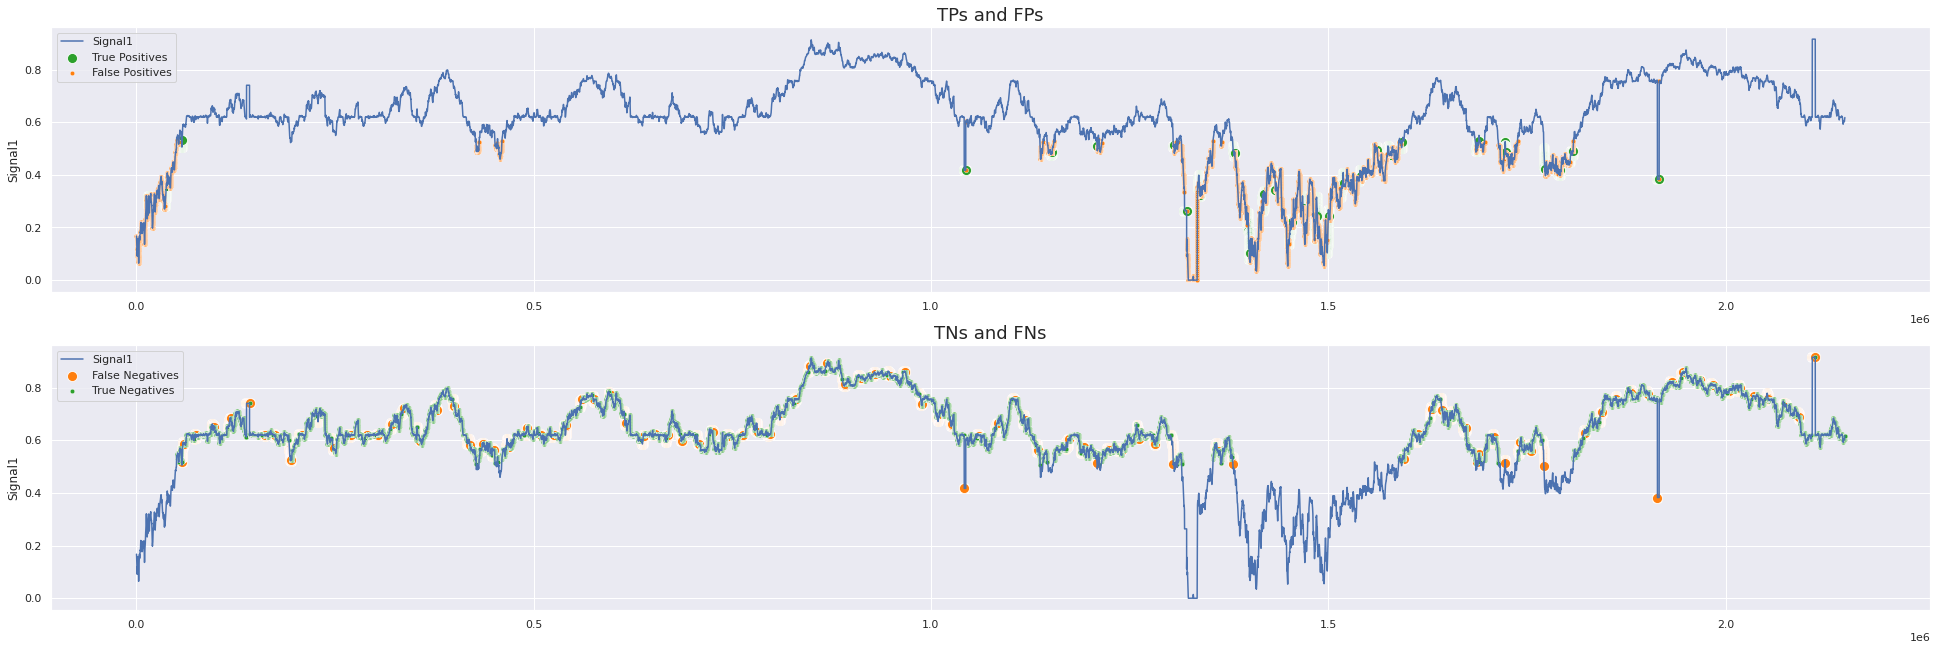

In [145]:
# plt.figure(figsize=(30,10))
fig,axs = plt.subplots(2,1,squeeze=False, figsize=(30,10))
axs[0,0].set_title('TPs and FPs',fontsize=18)
axs[0,0].plot(
test_score_df.index, 
test_score_df.Signal1,
label='Signal1'
)

sns.scatterplot(
  TPs.index, 
  TPs.Signal1,
  color=sns.color_palette("tab10")[2],
  s=100,
  markers='o',
  label='True Positives',
  ax = axs[0,0]
)

sns.scatterplot(
  FPs.index, 
  FPs.Signal1,
  color=sns.color_palette("tab10")[1],
  s=20,
  label='False Positives',
  ax = axs[0,0]
)
plt.legend()

axs[1,0].set_title('TNs and FNs',fontsize=18)

axs[1,0].plot(
test_score_df.index, 
test_score_df.Signal1, 
  label='Signal1'
)

sns.scatterplot(
  FNs.index, 
  FNs.Signal1,
  color=sns.color_palette("tab10")[1],
  s=100,
  markers='o',
  label='False Negatives',
  ax = axs[1,0]
)
sns.scatterplot(
  TNs.index, 
  TNs.Signal1,
  color=sns.color_palette("tab10")[2],
  s=20,
  markers='o',
  label='True Negatives',
  ax = axs[1,0]
)

[[  9659  47614  39302 203392]]


([<matplotlib.patches.Wedge at 0x7f5bccaaf438>,
 [Text(1.1938652338855817, 0.12118499626325624, 'TPs'),
  Text(0.8406263074607292, 0.709469809931994, 'FPs'),
  Text(-0.0485548162678237, 1.1990172766967113, 'FNs'),
  Text(-0.5837027302554357, -0.932357829747973, 'TNs')])

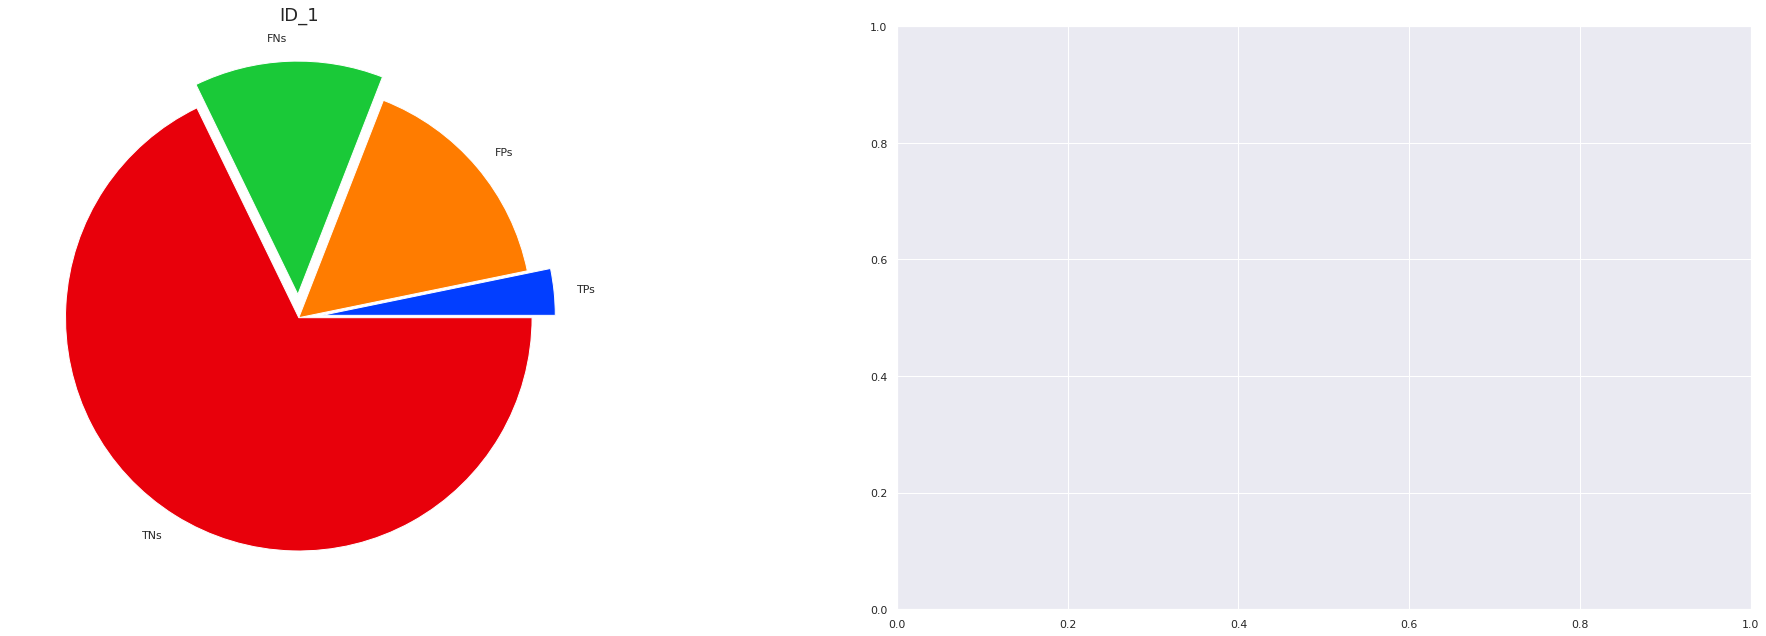

In [128]:
print(stats)

pallete = sns.color_palette('bright')
fig,axs = plt.subplots(1,2,squeeze=False, figsize=(30,10))
fig.set_facecolor('white')
labels = ['TPs', 'FPs', 'FNs', 'TNs']
explode = (0.1, 0, 0.1, 0)

axs[0,0].set_title('ID_1',fontsize=18)
axs[0,0].pie(
stats[0],
labels = labels,
colors = pallete,
explode = explode,
 )


[[  6229  33474  42732 217532]]


([<matplotlib.patches.Wedge at 0x7f5bccefcd30>,
 [Text(1.1974473770789305, 0.07822901716620062, 'TPs'),
  Text(0.9751596555055854, 0.508982952832635, 'FPs'),
  Text(0.34501592423351407, 1.1493319851223553, 'FNs'),
  Text(-0.7148827242103878, -0.8360279245488962, 'TNs')])

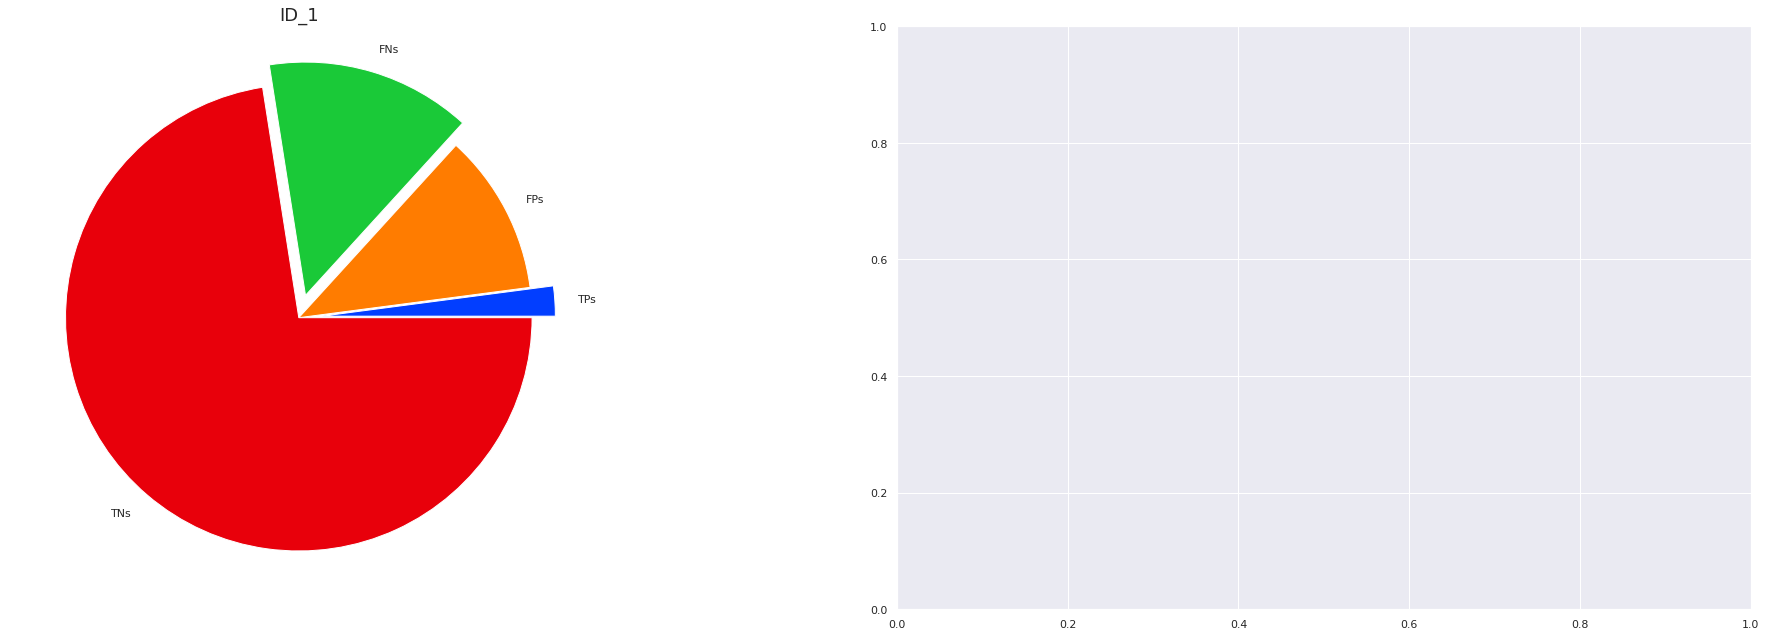

In [111]:
print(stats)

pallete = sns.color_palette('bright')
fig,axs = plt.subplots(1,2,squeeze=False, figsize=(30,10))
fig.set_facecolor('white')
labels = ['TPs', 'FPs', 'FNs', 'TNs']
explode = (0.1, 0, 0.1, 0)

axs[0,0].set_title('ID_1',fontsize=18)
axs[0,0].pie(
stats[0],
labels = labels,
colors = pallete,
explode = explode,
 )


In [79]:
def tpr_fpr_cal(anom,notAnom):

    TPs = anom[anom.Label == anom.anomaly]
    FPs = anom[anom.Label != anom.anomaly]
    FNs= notAnom[notAnom.Label != notAnom.anomaly]
    TNs= notAnom[notAnom.Label == notAnom.anomaly]

    tpr = TPs.iloc[:,0].shape[0] / (TPs.iloc[:,0].shape[0] + FNs.iloc[:,0].shape[0])
    fpr = FPs.iloc[:,0].shape[0]/ (FPs.iloc[:,0].shape[0] + TNs.iloc[:,0].shape[0])
    # print(tpr)
    # print(fpr)

    return tpr,fpr

In [118]:
def roc_from_scratch(test_df, partitions=100):
    roc = np.array([])
    for i in range(partitions + 1):
        anomalies = test_df[test_df.loss > (i / partitions)]
        notAnomalies =  test_df[test_df.loss <= (i / partitions)]
        
        # print(notAnomalies)
        tpr, fpr = tpr_fpr_cal(anomalies, notAnomalies)
        if(0.58 > tpr < 0.6):
            print(i / partitions)

        roc = np.append(roc, [fpr, tpr])
        # print(roc)
        
    return roc.reshape(-1, 2)

0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.57
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.69
0.7
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.82
0.83
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99
1.0


Text(0, 0.5, 'True Positive Rate')

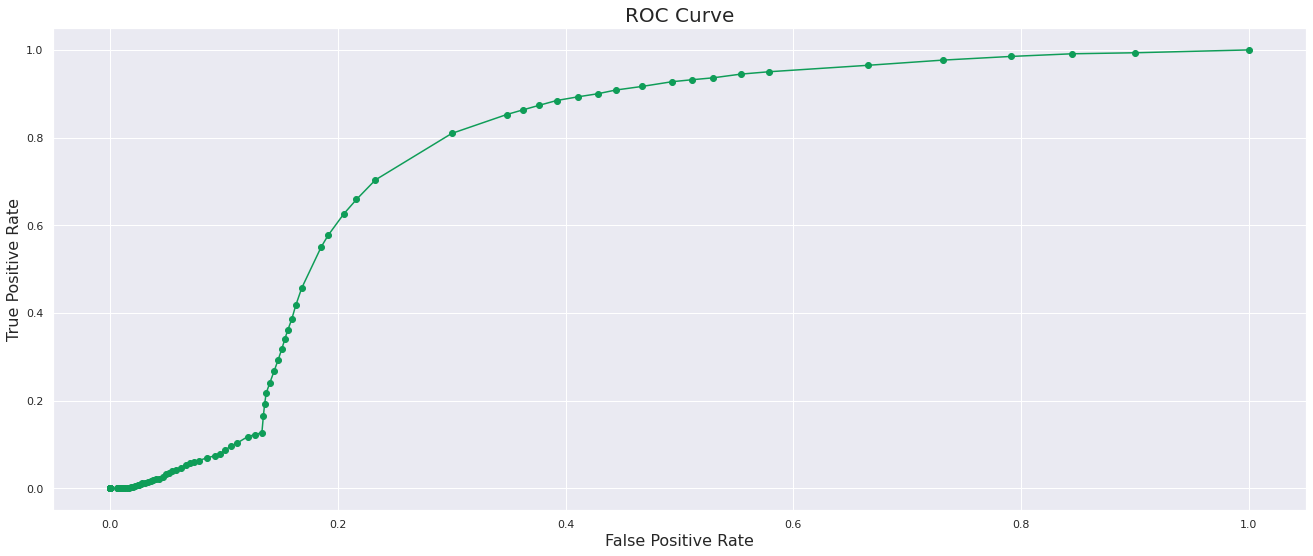

In [119]:
roc = roc_from_scratch(test_score_df)
plt.plot(roc[:,0],roc[:,1],color='#0F9D58', marker='o')
plt.title('ROC Curve',fontsize=20)
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)